In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
import open3d as o3d
from utils import readRegistrationParamsFromHDF5, rotationMatrixToEulerAngles, readToothRowScalesFromHDF5, getRotMats, getRotMat, getRotAngles, showPointCloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
SHIFT_VEC = np.array([0.,10.,0.])
NUM_TOOTH = 28
NUM_PC = 50
INPUT_SHAPE = (NUM_TOOTH, *PG_SHAPE)
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
SRC_DIR_1 = r"./dataWithPhoto/cpdAlignedData/"
SRC_DIR_2 = r"./data/cpdAlignedData/"
PARAM_DIR_1 = r"./dataWithPhoto/params/"
PARAM_DIR_2 = r"./data/params/"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

In [4]:
def __getToothIndex(f):
    return int(os.path.basename(f).split(".")[0].split("_")[-1])

def loadMuEigValSigma(ssmDir, numPC=NUM_PC):
    """Mu.shape=(28,1500,3), sqrtEigVals.shape=(28,1,100), Sigma.shape=(28,4500,100)"""
    muNpys = glob.glob(os.path.join(ssmDir,"meanAlignedPG_*.npy"))
    muNpys = sorted(muNpys, key=lambda x:__getToothIndex(x))
    Mu = np.array([np.load(x) for x in muNpys])
    eigValNpys = glob.glob(os.path.join(ssmDir,"eigVal_*.npy"))
    eigValNpys = sorted(eigValNpys, key=lambda x:__getToothIndex(x))
    sqrtEigVals = np.sqrt(np.array([np.load(x) for x in eigValNpys]))
    eigVecNpys = glob.glob(os.path.join(ssmDir,"eigVec_*.npy"))
    eigVecNpys = sorted(eigVecNpys, key=lambda x:__getToothIndex(x))
    Sigma = np.array([np.load(x) for x in eigVecNpys])
    return Mu, sqrtEigVals[:,np.newaxis,:numPC], Sigma[...,:numPC]

def loadInvRegistrationParams(loadDir):
    """生成DataFrame,含有逆配准参数s,R,transVec,transVecShift"""
    """initPG = np.multiply(s, np.matmul(PG+transVec, R)) + transVecShift"""
    toothIndices = UPPER_INDICES + LOWER_INDICES
    paramDF = pd.DataFrame(columns=["tag"])
    # 下牙列逆配准参数
    tags, rowScales, transVecShifts = readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfLowerToothRow.hdf5"), "L")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"lower_s":list(invScales), "lower_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 上牙列逆配准参数
    tags, rowScales, transVecShifts = readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfUpperToothRow.hdf5"), "U")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"upper_s":list(invScales), "upper_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 牙齿统计形状逆配准参数
    for i in toothIndices:
        h5File = os.path.join(loadDir, "sRtParams_{}.hdf5".format(i))
        tags, scales, rotMats, transVecs = readRegistrationParamsFromHDF5(h5File, i)
        indexTag = [int(tag[:-1]) for tag in tags]
        invRotAngles = [rotationMatrixToEulerAngles(r.T) for r in rotMats]
        invScales = 1./scales
        invTransVecs = -transVecs
        tempDF = pd.DataFrame({"tag":indexTag,"{}s".format(i):list(invScales), "{}rxyz".format(i):list(invRotAngles),"{}txyz".format(i):list(invTransVecs)})
        paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    sUpperColumns = ["{}s".format(id) for id in UPPER_INDICES]
    sLowerColumns = ["{}s".format(id) for id in LOWER_INDICES]
    paramDF = paramDF[~paramDF[sUpperColumns].isna().all(axis=1)]
    paramDF = paramDF[~paramDF[sLowerColumns].isna().all(axis=1)] # 删除缺少上牙列或下牙列的数据
    paramDF = paramDF.sort_values(by="tag", ignore_index=True)
    return paramDF

def loadAlignedTeethPgWithMaskByIndex(index, pgShape=(1500,3), srcRootDir="./dataWithPhoto/cpdAlignedData"):
    pgTxts = [os.path.join(srcRootDir, str(tID), "{}U.txt".format(index)) for tID in UPPER_INDICES]
    pgTxts.extend([os.path.join(srcRootDir, str(tID), "{}L.txt".format(index)) for tID in LOWER_INDICES])
    masks = [os.path.exists(f) for f in pgTxts]
    PGs = [np.loadtxt(f) if mask==True else np.zeros(pgShape) for f,mask in zip(pgTxts,masks)]
    return np.array(masks), np.array(PGs)

def getScalesRxyzTxyzRotMats(invParamDF, index):
    """计算s,rxyz,txyz,rotMats (nan用0填充)
    txyz = np.multiply(s, np.matmul(transVec, rotMats)) + transVecShift"""
    sColumns = ["{}s".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    rxyzColumns = ["{}rxyz".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    postTxyzColumns = ["{}txyz".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    indexedRow = invParamDF[invParamDF["tag"]==index]
    
    scaleList = indexedRow[sColumns].values.flatten().tolist()
    scales = [s if not np.isnan(s) else 0. for s in scaleList]
    scales = np.array(scales)[:,np.newaxis,np.newaxis]
    
    rxyzList = indexedRow[rxyzColumns].values.flatten().tolist()
    rxyzs = [rxyz if not np.isnan(rxyz).any() else np.zeros((3,)) for rxyz in rxyzList]
    rotMats = [getRotMat(rxyz) if not np.isnan(rxyz).any() else np.zeros((3,3)) for rxyz in rxyzList]
    
    postTxyzList = indexedRow[postTxyzColumns].values.flatten().tolist()
    transVecs = [txyz if not np.isnan(txyz).any() else np.zeros((3,)) for txyz in postTxyzList]
    transVecShifts = np.vstack([indexedRow["upper_ts"].values[0],indexedRow["lower_ts"].values[0]])
    transVecShifts = np.nan_to_num(transVecShifts, nan=0.0)
    txyzs = np.multiply(scales, np.matmul(np.array(transVecs)[:,np.newaxis,:], np.array(rotMats))) + np.array(transVecShifts)[:,np.newaxis,:]
    
    return scales, np.array(rxyzs), np.array(txyzs), np.array(rotMats)

def loadDataSet(paramDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR_2):
    Y_mask = [] # shape=(None,28,1,1)
    Y_scale = [] # shape=(None,28,1,1)
    Y_rxyz = [] # shape=(None,28,3)
    Y_txyz = [] # shape=(None,28,1,3)
    Y_fVec = [] # shape=(None,28,1,NUM_PC)
    X_pg = [] # shape=(None,28,1500,3)
    for i,index in enumerate(paramDF["tag"].values):
        mask, alignedPG = loadAlignedTeethPgWithMaskByIndex(index, pgShape, srcRootDir)
        mask = mask.reshape(-1,1,1)
        fVec = np.matmul((alignedPG - Mu).reshape(Mu.shape[0], 1, Mu.shape[1]*Mu.shape[2]), Sigma)
        scale, rxyz, txyz, rotMat = getScalesRxyzTxyzRotMats(paramDF, index)
        PG = np.multiply(mask, np.multiply(np.matmul(alignedPG, rotMat), scale) + txyz)
        Y_mask.append(mask)
        Y_scale.append(scale)
        Y_rxyz.append(rxyz)
        Y_txyz.append(txyz)
        Y_fVec.append(fVec)
        X_pg.append(PG)
        print("Load {}/{}".format(i+1,len(paramDF["tag"].values)))
    return X_pg, Y_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec

In [5]:
Mu, sqrtEigVals, Sigma = loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)

In [6]:
invRegistrationParamDF_1 = loadInvRegistrationParams(loadDir=PARAM_DIR_1)
invRegistrationParamDF_2 = loadInvRegistrationParams(loadDir=PARAM_DIR_2)

In [7]:
# X1_pg, Y1_mask, Y1_scale, Y1_rxyz, Y1_txyz, Y1_fVec = loadDataSet(invRegistrationParamDF_1, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR_1)

In [8]:
# X2_pg, Y2_mask, Y2_scale, Y2_rxyz, Y2_txyz, Y2_fVec = loadDataSet(invRegistrationParamDF_2, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR_2)

In [9]:
tempSaveDir = r"./res/"
X_pg_npy = os.path.join(tempSaveDir, "X_pg.npy")
X_mask_npy = os.path.join(tempSaveDir, "X_mask.npy")
X_covVec_npy = os.path.join(tempSaveDir, "X_covVec.npy")
# X_pg = X1_pg + X2_pg
# X_mask = Y1_mask + Y2_mask
# np.save(X_pg_npy, np.array(X_pg))
# np.save(X_mask_npy, np.array(X_mask))

In [10]:
numNeigh = 16
def findKNearestNeighbors(X, numNeigh):
    nbrs = NearestNeighbors(algorithm='auto', leaf_size=30, n_neighbors=numNeigh, p=2, radius=1.0, n_jobs=-1).fit(X) # p=2 is equivalent to the standard Euclidean metric
    neighIndices = nbrs.kneighbors(X, return_distance=False)
    return X[neighIndices]

def getLocalCovMats(X_pg, numNeigh): # very slow
    numSample, numTooth, numPoint, dim = X_pg.shape
    localCovMats = np.empty((numSample, numTooth, numPoint, 3, 3), dtype=np.float32)
    for i in range(numSample):
        for j in range(numTooth):
            X = X_pg[i,j]
            nbrs = findKNearestNeighbors(X, numNeigh)
            for k in range(numPoint):
                localCovMats[i,j,k] = np.cov(neighs[k],rowvar=False)
        print("Finish {}/{}".format(i+1,numSample))
    return localCovMats


def shiftUpperLowerToothRow(X_pg, shiftVec=SHIFT_VEC):
    shifted_X_pg = []
    for pg in X_pg:
        shifted_pg = np.concatenate([pg[:pg.shape[0]//2, ...]+shiftVec, pg[pg.shape[0]//2:, ...]-shiftVec], axis=0)
        shifted_X_pg.append(shifted_pg)
    return shifted_X_pg

In [11]:
# # 计算局部协方差矩阵
# LocalCovMats = getLocalCovMats(X_pg, numNeigh)
# X_covVec = LocalCovMats.reshape((*X_pg.shape[:-1],9))
# np.save(X_covVec_npy, np.array(X_covVec))

In [12]:
X_pg = np.load(X_pg_npy)
X_mask = np.load(X_mask_npy)
X_covVec = np.load(X_covVec_npy)
shifted_X_pg = shiftUpperLowerToothRow(X_pg, shiftVec=SHIFT_VEC)

In [13]:
def split_train_test_data(X_pg, X_mask, X_covVec, train_ratio=0.8):
    num = len(X_pg)
    indices = list(range(num))
    np.random.shuffle(indices)
    train = indices[:int(num*train_ratio)]
    test = indices[int(num*train_ratio):]
    return np.array(X_pg)[train], np.array(X_mask)[train], np.array(X_covVec)[train], np.array(X_pg)[test], np.array(X_mask)[test], np.array(X_covVec)[test]    

In [14]:
# X_pg_tr, Y_mask_tr, Y_scale_tr, Y_rxyz_tr, Y_txyz_tr, Y_fVec_tr, X_pg_tes, Y_mask_tes, Y_scale_tes, Y_rxyz_tes, Y_txyz_tes, Y_fVec_tes =\
#     split_train_test_data(shifted_X_pg, Y_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec, train_ratio=0.8)

X_pg_tr, X_mask_tr, X_covVec_tr, X_pg_tes, X_mask_tes, X_covVec_tes = split_train_test_data(shifted_X_pg, X_mask, X_covVec, train_ratio=0.8)

In [15]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, pg_list, mask_list, covVec_list, batch_size=2, train=True):
        self.batch_size = batch_size
        self.pg_list = pg_list
        self.mask_list = mask_list
        self.covVec_list = covVec_list
        self.train = train
        self.index_cnt = len(pg_list)
        self.index_list = list(range(self.index_cnt))
        self.on_epoch_end()
    def __len__(self):
        return self.index_cnt // self.batch_size
    def __getitem__(self, k):
        ks = k * self.batch_size
        kt = ks + self.batch_size
        x = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')
        mask = np.empty((self.batch_size, NUM_TOOTH, 1, 1), dtype='float32')
        covVec = np.empty((self.batch_size, NUM_TOOTH, NUM_POINT, 9), dtype='float32')
        y = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')
        for i, index in enumerate(range(ks, kt)):
            real_index = self.index_list[index]
            x[i] = self.pg_list[real_index]
            mask[i] = self.mask_list[real_index]
            covVec[i] = self.covVec_list[real_index]
            y[i] = self.pg_list[real_index]
        return [x,mask,covVec], y
    def on_epoch_end(self):
        if self.train == True:
            np.random.shuffle(self.index_list)

In [16]:
def leakyDense(x, filters, leaky_rate=.1, **kwargs):
    x = layers.Dense(filters, **kwargs)(x)
    x = layers.LeakyReLU(leaky_rate)(x)
    return x

def ParallelLeakyDense(x, filters, leaky_rate=.1):
    numT = x.shape[1]
    x_splits = tf.split(x, numT, axis=1)
    out = []
    for x_split in x_splits:
        out.append(layers.Dense(filters)(x_split))
    x = layers.Concatenate(axis=1)(out)
    x = layers.LeakyReLU(leaky_rate)(x)
    return x

# def LeakyConv1D(x, filters, k_size, leaky_rate=.1, dila=1):
#     x = layers.Conv1D(filters, kernel_size=k_size, dilation_rate=dila, padding='same')(x)
#     x = layers.LeakyReLU(leaky_rate)(x)
#     return x

def LeakyConv1D(x, filters, k_size, leaky_rate=.1, dila=1, **kwargs):
    # On Lab Computer tf2.1
    numT, numPoint, dim = x.shape[1:]
    x = layers.Reshape((numT*numPoint, dim))(x)
    x = layers.Conv1D(filters, kernel_size=k_size, dilation_rate=dila, padding='same', **kwargs)(x)
    x = layers.LeakyReLU(leaky_rate)(x)
    x = layers.Reshape((numT, numPoint, filters))(x)
    return x

# def ParallelLeakyConv1D(x, filters, k_size, leaky_rate=.1, dila=1):
#     numT = x.shape[1]
#     x_splits = tf.split(x, numT, axis=1)
#     out = []
#     for x_split in x_splits:
#         out.append(layers.Conv1D(filters, kernel_size=k_size, dilation_rate=dila, padding='same')(x_split))
#     x = layers.Concatenate(axis=1)(out)
#     x = layers.LeakyReLU(leaky_rate)(x)
#     return x

def ParallelLeakyConv1D(x, filters, k_size, leaky_rate=.1, dila=1):
    # On Lab Computer tf2.1
    numT, numPoint, dim = x.shape[1:]
    x_splits = tf.split(x, numT, axis=1)
    out = []
    for x_split in x_splits:
        x_split = layers.Reshape((numPoint, dim))(x_split)
        out.append(layers.Conv1D(filters, kernel_size=k_size, dilation_rate=dila, padding='same')(x_split))
    x = layers.Concatenate(axis=1)(out)
    x = layers.LeakyReLU(leaky_rate)(x)
    x = layers.Reshape((numT, numPoint, filters))(x)
    return x

def MultiConv1D(x, filters, k_size, conv_times, dial=1, leaky_rate=.1):
    x = LeakyConv1D(x, filters, 1)
    for _ in range(conv_times):
        inx = x
        x = LeakyConv1D(x, filters, k_size, leaky_rate, dial)
        x = layers.Add()([inx, x]) # Direct element-wise addition (similar to residual block)
    return x

def MultiDialConv1D(x, filters, k_size, conv_times, dial_rates=[1, 5, 9], leaky_rate=.1):
    out = []
    for dial in dial_rates:
        out.append(MultiConv1D(x, filters, k_size, conv_times, dial))
    return layers.Concatenate()(out)


class LayerComputeRotMatsByGramSchmidt(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LayerComputeRotMatsByGramSchmidt, self).__init__(**kwargs)
    def call(self, matrices2by3):
        return self.computeRotMatsByGramSchmidt(matrices2by3)
    def computeRotMatsByGramSchmidt(self, matrices2by3):
        numSample = tf.shape(matrices2by3)[0]
        numTooth = tf.shape(matrices2by3)[1]
        vecs_a1, vecs_a2 = tf.split(matrices2by3, 2, axis=2)
        vecs_b1, _ = tf.linalg.normalize(vecs_a1, ord='euclidean', axis=-1)
        vecs_b2 = vecs_a2 - tf.multiply(tf.matmul(vecs_b1, tf.transpose(vecs_a2,[0,1,3,2])), vecs_b1)
        vecs_b2, _ = tf.linalg.normalize(vecs_b2, ord='euclidean', axis=-1)
        vec_e1, vec_e2, vec_e3 = tf.split(tf.reshape(tf.eye(3),(1,1,3,3)), 3, axis=2)
        vecs_e1 = tf.tile(vec_e1, [numSample,numTooth,1,1])
        vecs_e2 = tf.tile(vec_e2, [numSample,numTooth,1,1])
        vecs_e3 = tf.tile(vec_e3, [numSample,numTooth,1,1])
        mats_U1 = tf.concat([vecs_b1,vecs_b2,vecs_e1], axis=2)
        dets_U1 = tf.linalg.det(mats_U1)
        mats_U2 = tf.concat([vecs_b1,vecs_b2,vecs_e2], axis=2)
        dets_U2 = tf.linalg.det(mats_U2)
        mats_U3 = tf.concat([vecs_b1,vecs_b2,vecs_e3], axis=2)
        dets_U3 = tf.linalg.det(mats_U3)
        vecs_b3 = tf.expand_dims(tf.stack([dets_U1,dets_U2,dets_U3], axis=-1), axis=2)
        rotMats = tf.concat([vecs_b1, vecs_b2, vecs_b3], axis=2)
        return rotMats
        
    
def computeRotMatsByGramSchmidt(matrices2by3):
    numSample = tf.shape(matrices2by3)[0]
    numTooth = tf.shape(matrices2by3)[1]
    vecs_a1, vecs_a2 = tf.split(matrices2by3, 2, axis=2)
    vecs_b1, _ = tf.linalg.normalize(vecs_a1, ord='euclidean', axis=-1)
    vecs_b2 = vecs_a2 - tf.multiply(tf.matmul(vecs_b1, tf.transpose(vecs_a2,[0,1,3,2])), vecs_b1)
    vecs_b2, _ = tf.linalg.normalize(vecs_b2, ord='euclidean', axis=-1)
    vec_e1, vec_e2, vec_e3 = tf.split(tf.reshape(tf.eye(3),(1,1,3,3)), 3, axis=2)
    vecs_e1 = tf.tile(vec_e1, [numSample,numTooth,1,1])
    vecs_e2 = tf.tile(vec_e2, [numSample,numTooth,1,1])
    vecs_e3 = tf.tile(vec_e3, [numSample,numTooth,1,1])
    mats_U1 = tf.concat([vecs_b1,vecs_b2,vecs_e1], axis=2)
    dets_U1 = tf.linalg.det(mats_U1)
    mats_U2 = tf.concat([vecs_b1,vecs_b2,vecs_e2], axis=2)
    dets_U2 = tf.linalg.det(mats_U2)
    mats_U3 = tf.concat([vecs_b1,vecs_b2,vecs_e3], axis=2)
    dets_U3 = tf.linalg.det(mats_U3)
    vecs_b3 = tf.expand_dims(tf.stack([dets_U1,dets_U2,dets_U3], axis=-1), axis=2)
    rotMats = tf.concat([vecs_b1, vecs_b2, vecs_b3], axis=2)
    return rotMats




def computeRotMat(batched_rxyz):
    numTooth = batched_rxyz.shape[1]
    batched_cosxyz = tf.cos(batched_rxyz)
    batched_sinxyz = tf.sin(batched_rxyz)
    vec_cx, vec_cy, vec_cz = tf.split(batched_cosxyz, 3, axis=-1)
    vec_cx, vec_cy, vec_cz = tf.squeeze(vec_cx,axis=-1), tf.squeeze(vec_cy,axis=-1), tf.squeeze(vec_cz,axis=-1)
    vec_sx, vec_sy, vec_sz = tf.split(batched_sinxyz, 3, axis=-1)
    vec_sx, vec_sy, vec_sz = tf.squeeze(vec_sx,axis=-1), tf.squeeze(vec_sy,axis=-1), tf.squeeze(vec_sz,axis=-1)
    vec_1 = tf.ones_like(vec_cx)
    vec_0 = tf.zeros_like(vec_cx)

    rotMatXs = tf.stack([vec_1,vec_0,vec_0, vec_0,vec_cx,vec_sx, vec_0,-vec_sx,vec_cx], axis=-1)
    rotMatXs = layers.Reshape((numTooth,3,3))(rotMatXs)
    rotMatYs = tf.stack([vec_cy,vec_0,-vec_sy, vec_0,vec_1,vec_0, vec_sy,vec_0,vec_cy], axis=-1)
    rotMatYs = layers.Reshape((numTooth,3,3))(rotMatYs)
    rotMatZs = tf.stack([vec_cz,vec_sz,vec_0, -vec_sz,vec_cz,vec_0, vec_0,vec_0,vec_1], axis=-1)
    rotMatZs = layers.Reshape((numTooth,3,3))(rotMatZs)
    
    rotMats = tf.matmul(rotMatXs, rotMatYs)
    rotMats = tf.matmul(rotMats, rotMatZs)
    return rotMats




def computePointClouds(tensorVars):
    mask, s, rotMat, txyz, rawFVec, Mu, SqrtEigVals, SigmaT, shiftVec = tensorVars
    # mask.shape = (None,28,1,1)
    # s.shape = (None,28,1,1)
    # rotMat.shape = (None,28,3,3)
    # txyz.shape = (None,28,1,3)
    # rawFVec.shape = (None,28,1,NUM_PC)
    # Mu.shape = (1,28,1500,3)
    # SqrtEigVals.shape = (1,28,1,NUM_PC)
    # SigmaT.shape = (1,28,NUM_PC,4500)
    # shiftVec = (1,28,1,3)
    pointDispl = tf.matmul(tf.multiply(SqrtEigVals, rawFVec), SigmaT)
    pointDispl = layers.Reshape(Mu.shape[1:])(pointDispl)
    pointAligned = tf.add(Mu, pointDispl)
    pointRotated = tf.matmul(pointAligned, rotMat)
    pointRotatedScaled = tf.multiply(s, pointRotated)
    pointRotatedScaledTranslated = tf.add(pointRotatedScaled, txyz)
    pointMasked = tf.multiply(mask, pointRotatedScaledTranslated)
    pointSplit = tf.split(pointMasked, num_or_size_splits=2, axis=1)
    pointShifted = tf.concat([tf.add(pointSplit[0],shiftVec), tf.add(pointSplit[1],-shiftVec)], axis=1)
    return pointShifted

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # print("z_mean.shape: ", tf.shape(z_mean))
        batch = tf.shape(z_mean)[0]
        sub_batch = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        epsilon = tf.keras.backend.random_normal(shape=(batch, sub_batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def distance_matrix(array1, array2):
    """
    arguments: 
        array1: the array, size: (num_point, num_feature)
        array2: the samples, size: (num_point, num_feature)
    returns:
        distances: each entry is the distance from a sample to array1
            , it's size: (num_point, num_point)
    """
    # num_point, num_features = array1.shape
    num_point, num_features = tf.shape(array1)[0], tf.shape(array1)[1]
    expanded_array1 = tf.tile(array1, [num_point, 1])
    expanded_array2 = tf.reshape(
            tf.tile(tf.expand_dims(array2, 1), 
                    [1, num_point, 1]),
            (-1, num_features))
    distances = tf.norm(expanded_array1-expanded_array2, axis=1)
    distances = tf.reshape(distances, (num_point, num_point))
    return distances

def av_dist(array1, array2):
    """
    arguments:
        array1, array2: both size: (num_points, num_feature)
    returns:
        distances: size: (1,)
    """
    distances = distance_matrix(array1, array2)
    distances = tf.reduce_min(distances, axis=1)
    distances = tf.reduce_mean(distances)
    return distances

def av_dist_sum(arrays):
    """
    arguments:
        arrays: array1, array2
    returns:
        sum of av_dist(array1, array2) and av_dist(array2, array1)
    """
    array1, array2 = arrays
    av_dist1 = av_dist(array1, array2)
    av_dist2 = av_dist(array2, array1)
    return av_dist1+av_dist2

def chamfer_distance_tf(y_true, y_pred):
    batch_size, sub_batch_size, num_point, num_features = tf.shape(y_true)[0], tf.shape(y_true)[1], tf.shape(y_true)[2], tf.shape(y_true)[3]
    y_true = tf.reshape(y_true, (batch_size*sub_batch_size, num_point, num_features))
    y_pred = tf.reshape(y_pred, (batch_size*sub_batch_size, num_point, num_features))
    dist = tf.reduce_mean(
               tf.map_fn(av_dist_sum, elems=(y_true, y_pred), dtype=tf.float32))
    return dist

def custom_square_L2_loss(y_true, y_pred):
    square_l2_errors = tf.reduce_sum(tf.square(y_true-y_pred), axis=-1)
    square_l2_error = tf.reduce_mean(square_l2_errors)
    return square_l2_error


In [17]:
def CreateSemiAutoEncoder(inputShape, Mu, SqrtEigVals, SigmaT, ShiftVec, filters=[16,32,128,128,256], \
                             paramFilters=[256,128,128,64,32], fVecFilters = [512,1024,512,256,128]):  
    numT = inputShape[0]
    numPoint = inputShape[1]
    numPC = SqrtEigVals.shape[-1]
    
    inPG = layers.Input(inputShape, name="inputPG")
    inMask = layers.Input((numT,1,1), name="inputMask")
    inCovVec = layers.Input((numT,numPoint,9), name="inputCovVec")
    
    x = layers.Concatenate(axis=-1)([inPG,inCovVec])
    print(x.shape)
    kern_size = 1
    for idx,f in enumerate(filters):
        x = ParallelLeakyConv1D(x, f, kern_size)
        # x = LeakyConv1D(x, f, kern_size, name="encoder_conv1D_{}".format(idx))
        x = layers.BatchNormalization()(x)
        print(x.shape)
    
    x_max = layers.MaxPooling2D((1,numPoint))(x)
    x_avg = layers.AveragePooling2D((1,numPoint))(x)
    x = layers.Add()([x_max,x_avg])
    x = layers.Reshape((numT, x.shape[-1]))(x) #(None,28,256)
    
    print("bottle neck x.shape: ", x.shape)
    
    mask = inMask
    y1 = x
    for idx,f in enumerate(paramFilters):
        y1 = leakyDense(y1, f, name="decoder_dense_y1_{}".format(idx))
    # y1_mean = layers.Dense(1, activation="tanh", name="decoder_dense_y1_mean")(y1)
    # y1_log_var = layers.Dense(1, name="decoder_dense_y1_log_var")(y1)
    # y1 = Sampling()([y1_mean, y1_log_var])
    # scale = 1. + 0.3 * y1
    scale = 1. + 0.3 * layers.Dense(1, activation="tanh", name="decoder_dense_scale")(y1) # scale factor of each tooth
    scale = layers.Reshape((numT,1,1))(scale)
    print("scale.shape: ", scale.shape)
    
    y2 = x
    for idx,f in enumerate(paramFilters):
        y2 = leakyDense(y2, f, name="decoder_dense_y2_{}".format(idx))
    # y2_mean = layers.Dense(3, activation="tanh", name="decoder_dense_y2_mean")(y2)
    # y2_log_var = layers.Dense(3, name="decoder_dense_y2_log_var")(y2)
    # y2 = Sampling()([y2_mean, y2_log_var])
    # rxyz = y2
    rxyz = 1.0 * layers.Dense(3, activation="tanh", name="decoder_dense_rxyz")(y2) # euler rotation angles
    rotMat = layers.Lambda(computeRotMat)(rxyz)

    # matrices2by3 = layers.Dense(6, activation="tanh")(y2)
    # matrices2by3 = layers.Reshape((numT,2,3))(matrices2by3)
    # rotMat = LayerComputeRotMatsByGramSchmidt()(matrices2by3)
    # # rotMat = layers.Lambda(computeRotMatsByGramSchmidt)(matrices2by3)
    
    y3 = x
    for idx,f in enumerate(paramFilters):
        y3 = leakyDense(y3, f, name="decoder_dense_y3_{}".format(idx))
    # y3_mean = layers.Dense(3, name="decoder_dense_y3_mean")(y3)
    # y3_log_var = layers.Dense(3, name="decoder_dense_y3_log_var")(y3)
    # y3 = Sampling()([y3_mean, y3_log_var])
    # txyz = y3
    txyz = layers.Dense(3, name="decoder_dense_txyz")(y3)
    txyz = layers.Reshape((numT,1,3))(txyz) # translation vectors
    
    y4 = x
    for idx,f in enumerate(fVecFilters):
        y4 = leakyDense(y4, f, name="decoder_dense_y4_{}".format(idx))
    # y4_mean = 3. * layers.Dense(numPC, activation="tanh", name="decoder_dense_y4_mean")(y4)
    # y4_log_var = layers.Dense(numPC, name="decoder_dense_y4_log_var")(y4)
    # y4 = Sampling()([y4_mean, y4_log_var])
    # rawFVec = y4
    rawFVec = 3. * layers.Dense(numPC, activation="tanh", name="decoder_dense_rawFVec")(y4) # -3 ~ 3
    rawFVec = layers.Reshape((numT,1,numPC))(rawFVec) # feature vectors of PCA
    
    outPG = layers.Lambda(computePointClouds)((mask, scale, rotMat, txyz, rawFVec, Mu, SqrtEigVals, SigmaT, ShiftVec))
    
    model = keras.Model([inPG,inMask,inCovVec], outPG, name='AutoEncoder')
    return model

In [18]:
batch_size = 1
train_dg = DataGenerator(X_pg_tr, X_mask_tr, X_covVec_tr, batch_size, True)
valid_dg = DataGenerator(X_pg_tes, X_mask_tes, X_covVec_tes, batch_size, False)

In [19]:
SigmaT = np.transpose(Sigma,(0,2,1))
tensorMu = tf.constant(Mu, shape=(1,*Mu.shape))
tensorSigmaT = tf.constant(SigmaT, shape=(1,*SigmaT.shape))
tensorSqrtEigVals = tf.constant(sqrtEigVals, shape=(1,*sqrtEigVals.shape))
ShiftVec = tf.constant(SHIFT_VEC, shape=(1,*SHIFT_VEC.shape))
model = CreateSemiAutoEncoder(INPUT_SHAPE, tensorMu, tensorSqrtEigVals, tensorSigmaT, ShiftVec, filters=[32, 64, 128, 128, 256])

(None, 28, 1500, 12)
(None, 28, 1500, 32)
(None, 28, 1500, 64)
(None, 28, 1500, 128)
(None, 28, 1500, 128)
(None, 28, 1500, 256)
bottle neck x.shape:  (None, 28, 256)
scale.shape:  (None, 28, 1, 1)


In [20]:
model.summary()

Model: "AutoEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputPG (InputLayer)            [(None, 28, 1500, 3) 0                                            
__________________________________________________________________________________________________
inputCovVec (InputLayer)        [(None, 28, 1500, 9) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28, 1500, 12) 0           inputPG[0][0]                    
                                                                 inputCovVec[0][0]                
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 1, 1500, 12) 0           concatenate[0][0]      

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=custom_square_L2_loss)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=chamfer_distance_tf) #Out of Memory
model.load_weights('./res/ckpt/autoEncoder.h5')

In [22]:
ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=1, verbose=1)

177/177 [==============================] - 67s 232ms/step - loss: 0.7224 - val_loss: 0.6357


In [46]:
def computeCorrePointDistance(y, py):
    return np.linalg.norm(y.reshape(-1,3)-py.reshape(-1,3), axis=1, ord=2)

def computeMeanCustomMSELoss(y, py):
    return np.mean(np.linalg.norm(y.reshape(-1,3)-py.reshape(-1,3), axis=1, ord=2)**2)

In [47]:
saveDir = r"./res/"
groundTruthDir = os.path.join(saveDir, "y_true")
predictionDir = os.path.join(saveDir, "y_pred")
if not os.path.exists(groundTruthDir):
    os.makedirs(groundTruthDir)
if not os.path.exists(predictionDir):
    os.makedirs(predictionDir)
TestDataCorrePointDists = []
TestDataCustomMSELoss = []

bs = valid_dg.batch_size
for i in range(valid_dg.index_cnt//bs):
    xi, yi = valid_dg[i]
    pyi = model.predict(xi)
    for j in range(bs):
        TestDataCorrePointDists.append(computeCorrePointDistance(yi[j], pyi[j]))
        TestDataCustomMSELoss.append(computeMeanCustomMSELoss(yi[j], pyi[j]))
        np.savetxt(os.path.join(groundTruthDir,"{}.txt".format(i*bs+j)), yi[j].reshape(-1,3))
        np.savetxt(os.path.join(predictionDir,"{}.txt".format(i*bs+j)), pyi[j].reshape(-1,3))

print("average corre point dist on test dataset: {:.4f}mm".format(np.mean(TestDataCorrePointDists)))
print("average custom L2 loss on test dataset: {:.4f}".format(np.mean(TestDataCustomMSELoss)))

average corre point dist on test dataset: 0.6334mm
average custom L2 loss on test dataset: 0.5687


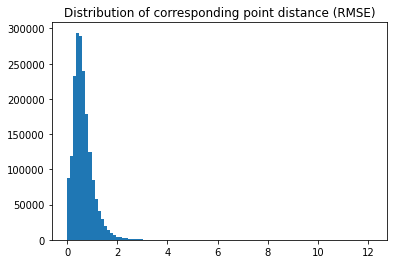

In [48]:
plt.hist(np.array(TestDataCorrePointDists).flatten(), bins=100)
plt.title("Distribution of corresponding point distance (RMSE)")
plt.show()

In [49]:
MuDataCorrePointDists = []

for mask,yi in zip(X_mask_tes,X_pg_tes):
    maskedMu = np.multiply(mask, Mu) # 使用牙列均值作为预测
    shiftMu = np.concatenate([maskedMu[:Mu.shape[0]//2, ...]+SHIFT_VEC, maskedMu[Mu.shape[0]//2:, ...]-SHIFT_VEC], axis=0)
    errors = computeCorrePointDistance(yi, shiftMu)
    MuDataCorrePointDists.append(errors)

MuDataCorrePointDists = np.array(MuDataCorrePointDists).flatten()
print("average corre point dist with Mu: {:.4f}mm".format(np.mean(MuDataCorrePointDists)))
print("average custom L2 loss with Mu: {:.4f}".format(np.mean(np.square(MuDataCorrePointDists))))

average corre point dist with Mu: 1.8767mm
average custom L2 loss with Mu: 5.1657


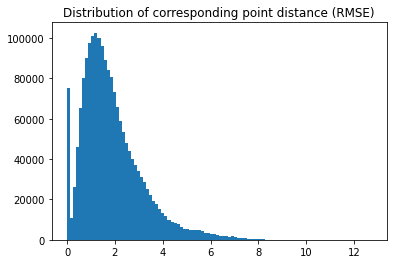

In [50]:
plt.hist(MuDataCorrePointDists, bins=100)
plt.title("Distribution of corresponding point distance (RMSE)")
plt.show()

In [52]:
model.save_weights('./res/ckpt/autoEncoder.h5')

In [ ]:
# model.load_weights('./res/ckpt/autoEncoder.h5', by_name=True)